## Introduction

This notebook demonstrates how to use neural network model for 
[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/)
dataset.

The model is based on [the keras code example](https://keras.io/examples/structured_data/imbalanced_classification/).

## Imports

In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras

## Load and Explore data

In [4]:
def helper_data_load(df):
    import uuid
    trxn_id = [uuid.uuid4().hex for _ in range(len(df))]
    assert len(set(trxn_id)) == len(trxn_id)
    df.insert(0, 'trxn_id', trxn_id)
    df = df.drop('Time', axis=1)
    return df

# Get the real data from 
fname = "/home/datashare/datasets/creditcard.csv"
df = pd.read_csv(fname)
df = helper_data_load(df)

print(df.shape)
df.head()

(284807, 31)


,trxn_id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,c8fd4617afa44f288e9e3c769b14a5d7,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,f22fae0e0c6147f58c8449a9eeef094c,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,37b523d698e04b5a9222f136ec762234,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3b3a024d15b04aa594e4c98817f8f7af,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,b64cf5a31f6745bfbb322301d761e4ad,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


{0: 284315, 1: 492}


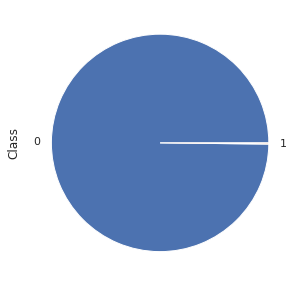

In [5]:
# explore class imbalance
class_counts = df['Class'].value_counts()

print(class_counts.to_dict())

class_counts.plot.pie(y='mass', figsize=(5, 5));

## Prepare train/valid/test datasets

In [6]:
features = df.loc[:,'V1':'Amount'].values
targets = df.loc[:,'Class':].values

In [7]:
# define data split
n = len(features)
n_train = int(n * 0.6)
n_valid = (n - n_train) // 2

# create indexes
idxs = np.arange(n)
train_idxs = idxs[:n_train]
valid_idxs = idxs[n_train:n_train+n_valid]
test_idxs = idxs[n_train+n_valid:]

print(f' total: {n}\n train: {n_train}\n valid: {n_valid}\n  test: {len(test_idxs)}')

 total: 284807
 train: 170884
 valid: 56961
  test: 56962


In [8]:
# split data
train = {
    'features': features[train_idxs],
    'targets': targets[train_idxs],
}

valid = {
    'features': features[valid_idxs],
    'targets': targets[valid_idxs],
}

test = {
    'features': features[test_idxs],
    'targets': targets[test_idxs],
}

print("Train data:")
print("features:", train['features'].shape)
print("frauds:", train['targets'].sum())
print()
print("Valid data:")
print("features:", valid['features'].shape)
print("frauds:", valid['targets'].sum())
print()
print("Test data:")
print("features:", test['features'].shape)
print("frauds:", test['targets'].sum())

Train data:
features: (170884, 29)
frauds: 360

Valid data:
features: (56961, 29)
frauds: 57

Test data:
features: (56962, 29)
frauds: 75


## Create preprocessing pipeline and transform data

In [9]:
preprocessor = StandardScaler()

X_train = preprocessor.fit_transform(train['features'])
X_valid = preprocessor.transform(valid['features'])
X_test = preprocessor.transform(test['features'])

y_train = train['targets']
y_valid = valid['targets']
y_test = test['targets']

#pickle.dump(preprocessor, open('preprocessor.pkl', 'wb'))
#preprocessor = pickle.load(open('preprocessor.pkl', 'rb'))

## Build a binary classification model

In [20]:
def build_model(input_dim):
    model = keras.Sequential([
            keras.layers.Dense(256, activation="relu", input_shape=(input_dim,)),

            keras.layers.Dense(256, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),

            keras.layers.Dense(256, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),

            keras.layers.Dense(1, activation="sigmoid"),
        ])
    return model

model = build_model(input_dim=X_train.shape[-1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               7680      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

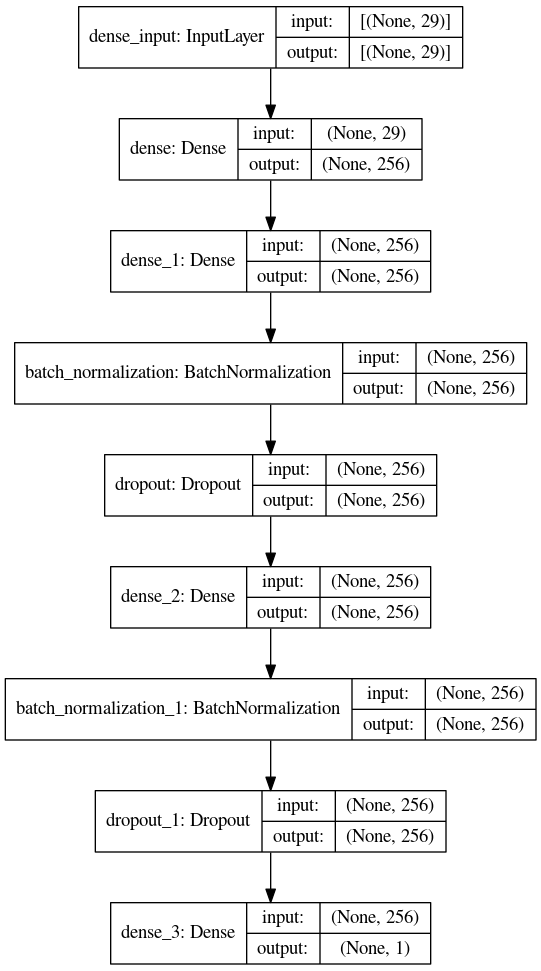

In [11]:
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [12]:
## Analyze class imbalance in the targets and compute class_weights
counts = np.bincount(train['targets'][:, 0])

ratio = counts[1], 100 * float(counts[1]) / len(train['targets'])
print( "Number of positive samples in training data: {} ({:.2f}% of total)".format(*ratio)) 

# define class weights for fitting the model 
class_weight = {
    0: 1.0 / counts[0],
    1: 1.0 / counts[1]
}

Number of positive samples in training data: 360 (0.21% of total)


In [13]:
#model = build_model(input_dim=X_train.shape[-1])
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=[keras.metrics.AUC(name='roc_auc')])

# Early Stopping Callback
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)
]

history = model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
)

#model.save('fraud_keras_model')
#model.load('fraud_keras_model')

Epoch 1/100


2022-12-13 09:05:07.238752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


668/668 - 4s - loss: 5.8562e-06 - roc_auc: 0.9202 - val_loss: 0.5670 - val_roc_auc: 0.9514
Epoch 2/100
668/668 - 3s - loss: 3.7759e-06 - roc_auc: 0.9602 - val_loss: 0.3822 - val_roc_auc: 0.9493
Epoch 3/100
668/668 - 3s - loss: 2.8312e-06 - roc_auc: 0.9732 - val_loss: 0.2477 - val_roc_auc: 0.9561
Epoch 4/100
668/668 - 3s - loss: 2.2260e-06 - roc_auc: 0.9838 - val_loss: 0.1783 - val_roc_auc: 0.9550
Epoch 5/100
668/668 - 3s - loss: 1.8725e-06 - roc_auc: 0.9890 - val_loss: 0.1474 - val_roc_auc: 0.9552
Epoch 6/100
668/668 - 3s - loss: 1.5258e-06 - roc_auc: 0.9916 - val_loss: 0.1083 - val_roc_auc: 0.9624
Epoch 7/100
668/668 - 3s - loss: 1.4239e-06 - roc_auc: 0.9929 - val_loss: 0.0920 - val_roc_auc: 0.9593
Epoch 8/100
668/668 - 3s - loss: 1.1284e-06 - roc_auc: 0.9971 - val_loss: 0.0734 - val_roc_auc: 0.9585
Epoch 9/100
668/668 - 3s - loss: 1.1275e-06 - roc_auc: 0.9953 - val_loss: 0.0624 - val_roc_auc: 0.9529
Epoch 10/100
668/668 - 3s - loss: 8.5043e-07 - roc_auc: 0.9981 - val_loss: 0.0527 - v

best val_loss 0.008576247841119766


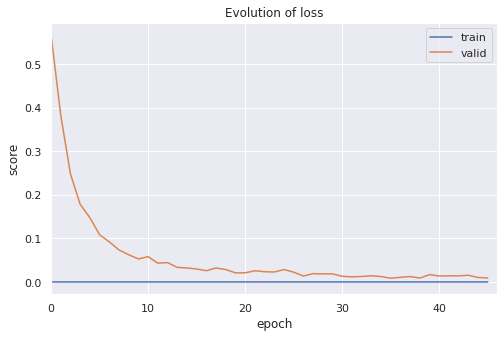

In [14]:
print('best val_loss', min(history.history['val_loss']))
                                       
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs.plot(history.history['loss'], label='train')
axs.plot(history.history['val_loss'], label='valid')

axs.set_xlim([0, len(history.history['loss'])])
axs.set_xlabel('epoch')
axs.set_ylabel('score')
axs.set_title("Evolution of loss")
axs.legend()

## Model evaluation

In [15]:
# compute metrics with keras
metrics_values = model.evaluate(X_test, y_test, batch_size=1024)
dict(zip(model.metrics_names, metrics_values))

56/56 [==============================] - 0s 2ms/step - loss: 0.0081 - roc_auc: 0.9241


{'loss': 0.008075742051005363, 'roc_auc': 0.9240657687187195}

In [16]:
# compute predictions
y_pred = model.predict(X_test, batch_size=1024)

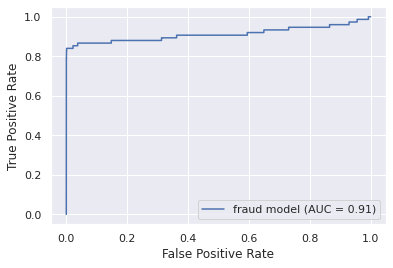

In [17]:
# ROC curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name='fraud model')
display.plot();

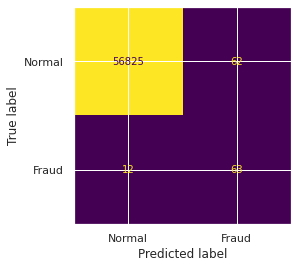

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred>0.5)
cm_display = ConfusionMatrixDisplay(cm, display_labels=('Normal', 'Fraud'))
cm_display.plot(colorbar=False);

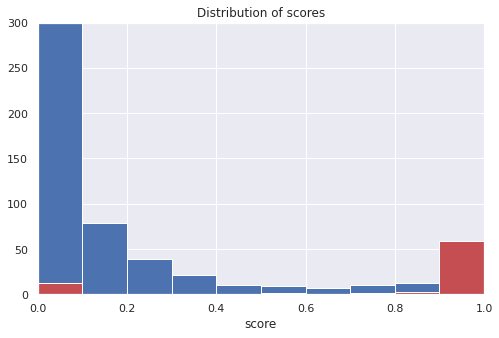

In [19]:
# distribution of scores
fig, axs = plt.subplots(1, figsize=(8, 5))

idx = 0
axs.hist(y_pred.ravel()[y_test.ravel()<1], color='b')
axs.hist(y_pred.ravel()[y_test.ravel()>0], color='r')

axs.set_xlim([0,1])
axs.set_ylim([0,300])
axs.set_xlabel('score')
axs.set_title("Distribution of scores")

plt.show()